# Cellphones price prediction:

In this notebook i built, using tools from pandas, numpy and sklearn libraries, an algorithm capable of predicting cellphones price ranges.

Two main objectives:
 * Getting an accuracy of at least 90%.
 * Use the lightest possible model.

The data used to train and test the model was taken from the following link:
https://www.kaggle.com/iabhishekofficial/mobile-price-classification?select=train.csv

## Libraries and function imports

In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import mysql.connector

# Inline plots
%matplotlib inline 


# Models we`ll try
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Others
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

## Importing / sploring the data

In [3]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="SAntafeclan1"
    )

mycursosr = db.cursor()
mycursosr.execute("use proyectos")

data = pd.read_sql("SELECT * FROM cellphones", con=db)
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
pd.set_option('display.max_columns', None) #I Want to see every column
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


The price is given by the last column, wich tells the price range of the phone, lets see hoy many price ranges there are:

In [5]:
# Four price ranges, perfectly balanced.
data["price_range"].value_counts()

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64

In [6]:
data.dtypes #Check if there are strings in the data 

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

In [7]:
# Every column contains only numerical values, encoding will not be necesary.
print(data.shape) #2000 ROWS, 21 COLUMNS (attributes)

(2000, 21)


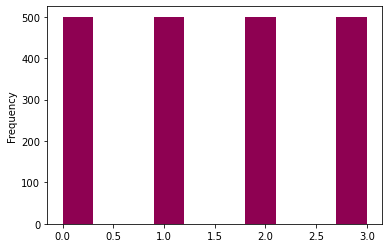

In [8]:
data["price_range"].plot.hist(cmap = "PiYG");
# Again, perfectly balanced...

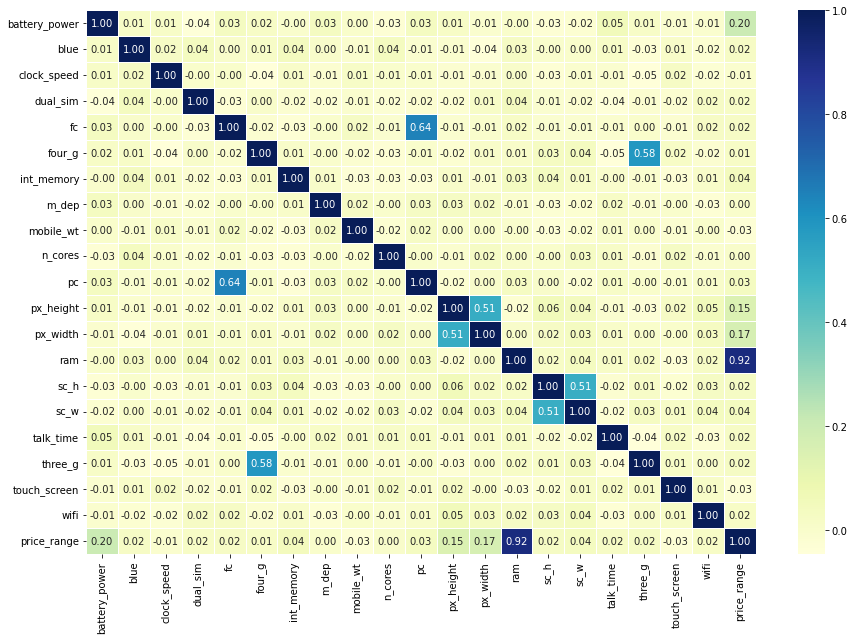

In [9]:
# Let`s create a correlation matrix to wee wich attributes are more important

corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths = 0.5,
                fmt=".2f",
                cmap="YlGnBu")

RAM memory has the highest correlation with the price... the highest the ram, the highest the price.

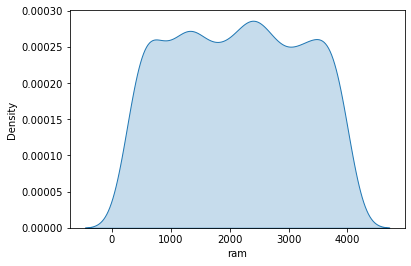

In [16]:
sns.kdeplot(x = "ram", data = data, shade = True);

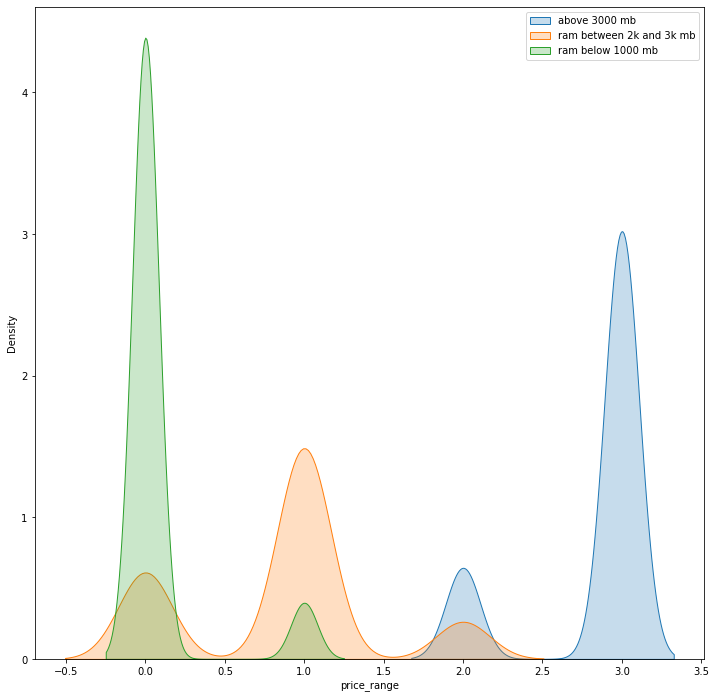

In [38]:
ram_above_3k = data[data["ram"] > 3000]
midstep = data[data["ram"] < 2000]
ram_between_1k_2k = midstep[midstep["ram"] > 1000]
ram_less_1k = data[data["ram"] < 1000]


fig = plt.subplots(figsize = (12,12))
sns.kdeplot(x = "price_range",
            data = ram_above_3k,
            shade = True, 
            label = "above 3000 mb");
sns.kdeplot(x = "price_range",
            data = ram_between_1k_2k,
            shade = True,
            label = "ram between 2k and 3k mb");
sns.kdeplot(x = "price_range",
            data = ram_less_1k,
            shade = True,
            label = "ram below 1000 mb");

plt.legend()

## Preparing the data:

In [11]:
# I split the data in attributes X and targets y
X = data.drop("price_range", axis = 1)
y = data["price_range"]

# I split the data in testing and training data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Let`s check everything is in order
print("X_train shape =", X_train.shape)
print("X_test shape=",X_test.shape)
print("y_train shape=", y_train.shape)
print("y_test shape=", y_test.shape)

X_train shape = (1600, 20)
X_test shape= (400, 20)
y_train shape= (1600,)
y_test shape= (400,)


## Modeling:
### I start by trying different algorithms

To chose the algorithms i used the map in the following link as a guide: 
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

I choosed these algorithms:
* RandomForestClassifier (ensemble)
* LinearSVC
* KNeighborsClassifier

In [12]:
# Let´s create a dictionary with the models we´ll test
models = {"RFC" : RandomForestClassifier() , "SVC" : LinearSVC() , "KNC" : KNeighborsClassifier()}

In [13]:
# This next function is innecesary since i´m not testing many models, i´ll use it anyway just to practice.

def fit_and_score(modelos, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates machine learning models inside
    a dictionary
    """
    #Set a random seed
    np.random.seed(42)
    #A dictionary to save the scores
    model_scores_test = {}
    # Iterate over the models
    for name, model in models.items():
        #Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores_test[name] = model.score(X_test, y_test)
    print ("Scores", model_scores_test)
    return model_scores_test

raw_model_scores = fit_and_score(models, X_train, X_test, y_train, y_test) # I save the scores here

Scores {'RFC': 0.89, 'SVC': 0.515, 'KNC': 0.91}


C:\Users\mateo\Desktop\Machine_Learning\Proyecto_propio_cel\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC is not fitting, i wont bother adjusting it´s hyperparameters since KNC and RFC are returning great results. Berfore
choosing KNC for being the more exact one, i´ll cross validate KNC and RFC to be shure thet KNC is performing better.

In [14]:
cv_acc_RFC = cross_val_score(models["RFC"], X, y, cv=5, scoring="accuracy")

cv_acc_KNC = cross_val_score (models["KNC"], X, y, cv=5, scoring = "accuracy")

In [15]:
# Again, KNC is performing better by a considerable margin.
print("RFC acc:", np.mean(cv_acc_RFC))
print("KNC acc:", np.mean(cv_acc_KNC))

RFC acc: 0.8755
KNC acc: 0.9195


Furthermore, as it can be seen in the next two cells, KNC is way faster,

In [16]:
%timeit cv_acc_RFC = cross_val_score(models["RFC"], X, y, cv=5, scoring="accuracy")

1.71 s ± 50.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:

%timeit cv_acc_KNC = cross_val_score(models["KNC"], X, y, cv=5, scoring = "accuracy")

149 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Hyperparameter tuning.

Given that KNC performs the best with our data, well choose it as our model and try to emprove it by tunning it´s hyperparámeters

In [18]:
# Let´s remember KNC hyperparámeters
models["KNC"].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [19]:
# I´ll use GridSearchCV 

# Let´s create a dictionary with the hyperparámeters we´ll try
np.random.seed(42)
KNC_grid = {"n_neighbors" : [3,5,11,19],
              "weights" : ["uniform" , "distance"],
              "metric" : ["euclidean" , "manhattan"], 
              "leaf_size" : [5, 10, 15]}

# Let´s create our GSCV instance
gs_KNC = GridSearchCV (KNeighborsClassifier(),
                       param_grid = KNC_grid,
                       cv = 5, # 5 folds
                       verbose = True,
                       n_jobs=1)

#Fit
gs_KNC.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'leaf_size': [5, 10, 15],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [20]:
# Let´s get the best params
bp = gs_KNC.best_params_
bp

{'leaf_size': 5,
 'metric': 'euclidean',
 'n_neighbors': 11,
 'weights': 'distance'}

In [21]:
# Let´s see if the model improved
gs_KNC.score(X_test, y_test)

0.9325

In [22]:
# It seems to have improved, anyway, i´ll test it again using Cross Validation to be shure

np.random.seed(42)

# Create an istance for KNC with the found hyperparámeters
KNC_opti = KNeighborsClassifier(metric = "euclidean",
                                n_neighbors = 11, 
                                weights = "distance") 

cv_acc_KNC_opti = cross_val_score (KNC_opti, X, y, cv=5, scoring = "accuracy")
print("la accuracy del modelo KN usando los mejores parámetros encontrados es", np.mean(cv_acc_KNC_opti))

la accuracy del modelo KN usando los mejores parámetros encontrados es 0.9355


Still better than the standard hyperparámeters. 

#### Let´s plot the models we tried so far

Text(0, 0.5, 'Accuracy')

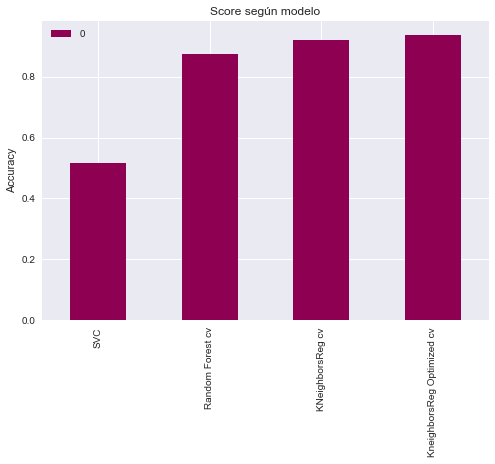

In [23]:
scores = {"SVC" : raw_model_scores["SVC"], 
          "Random Forest cv" : np.mean(cv_acc_RFC), 
          "KNeighborsReg cv" : np.mean(cv_acc_KNC), 
          "KneighborsReg Optimized cv" : np.mean(cv_acc_KNC_opti)}

scores_df = pd.DataFrame(scores, index = [0])

plt.style.use('seaborn')
scores_df.T.plot(kind = "bar", cmap = "PiYG" )
plt.title("Score según modelo")
plt.ylabel("Accuracy")

Maybe we can improve even more the KNC model if we keep tunning the hyperparámeters, but since the objective of having a over 90% accuracy has been acheved, we´ll live it like it is.
Next, i´ll study other metrics for the choosen model to get a complete vision of it´s performance.

## KneighborsReg: Evaluating the model

We´ll use:

    Confusion Matrix
    Classification report
    Precision
    Recall
    f1-Score

In [24]:
# Let´s make the predictions

KNC_opti.fit(X_train, y_train)
y_preds = KNC_opti.predict(X_test)

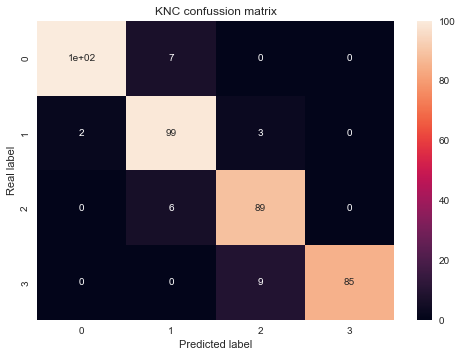

In [25]:
# A confussion matrix can be usefull to see where is the model making mistakes

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar= True)
plt.xlabel("Predicted label")
plt.ylabel("Real label")
plt.title("KNC confussion matrix");

In [26]:
# Let´s get a classification report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       107
           1       0.88      0.95      0.92       104
           2       0.88      0.94      0.91        95
           3       1.00      0.90      0.95        94

    accuracy                           0.93       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.94      0.93      0.93       400



Classification report uses only one split of the data. But some metrics in it can be calculated using Cross Validation:

In [27]:
# For completeness i´ll include cv score in this section
cv_acc = cross_val_score(KNC_opti,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_acc

0.9355

For the precision, recall and f1 score i´ll calculate the mean of the metrics for the four price ranges.

In [28]:
# Cross validated precision
cv_precision = cross_val_score(KNC_opti,
                         X,
                         y,
                         cv=5,
                         scoring="precision_macro")
cv_precision = np.mean(cv_precision)
cv_precision

0.9359710742479299

In [29]:
# Cross validated recall
cv_recall = cross_val_score(KNC_opti,
                         X,
                         y,
                         cv=5,
                         scoring="recall_macro")
cv_recall = np.mean(cv_recall)
cv_recall

0.9355

In [30]:
# Cross validated f1
cv_f1 = cross_val_score(KNC_opti,
                         X,
                         y,
                         cv=5,
                         scoring="f1_macro")
cv_f1 = np.mean(cv_f1)
cv_f1

0.9353443580572709

In [31]:
# Lets put all this in a plot

cv_metrics = pd.DataFrame({"Accuracy" : cv_acc,
                           "Precision" : cv_precision,
                           "Recall" : cv_recall,
                           "F1" : cv_f1}, index = [0])
cv_metrics

,Accuracy,Precision,Recall,F1
0,0.9355,0.935971,0.9355,0.935344


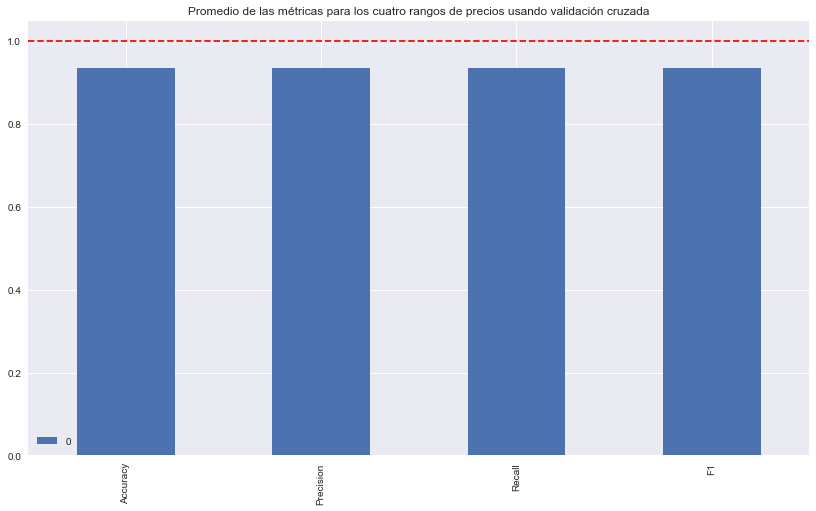

In [32]:
plt.style.use("seaborn")
cv_metrics.T.plot(kind="bar", figsize = (14,8) )
plt.axhline(y=1, color='r', linestyle='--')
plt.title("Promedio de las métricas para los cuatro rangos de precios usando validación cruzada");


By last, just for completeness, let´s save the model

In [33]:
from joblib import dump, load

# Guardo
dump(KNC_opti, filename="KNC_optimized.joblib") 

['KNC_optimized.joblib']